# Understanding Attention in Transformers  
This notebook demonstrates **self-attention** (used in GPT-like models) with a minimal example. Inspired by [Andrej Karpathy's lecture](https://youtu.be/kCc8FmEb1nY), we'll:  
1. Create toy embeddings for a sentence.  
2. Compute attention scores (weights) between tokens.  
3. Mask future tokens for autoregressive (causal) attention.  
4. Aggregate embeddings using weighted sums.  

Key idea: Each token's output is a weighted mix of *itself* and *past tokens*.

### Why Attention?  
Language models predict the next word by focusing on relevant past words. Consider a string "your cat is a lovely cat": 
- The first "cat" might attend to "your".  
- The second "cat" might attend to "your lovely".  
Attention weights (`wei`) decide how much focus each word gets.  

In [3]:
import torch
import torch.nn as nn 
import torch.nn.functional as F

## Step 1: Toy Embeddings  
We'll use a tiny sentence and map each word to a random 2D embedding (for visualization).  
- `stoi`: Word-to-index mapping.  
- `embedding_table`: Random embeddings (normally learned during training).  

For understanding, let's work with the string *"your cat is a lovely cat"* as an example.

In [4]:
# Set a fixed random seed for reproducibility (ensures consistent embeddings)
torch.manual_seed(1337);

# Sample sentence (6 tokens)
s = "your cat is a lovely cat"

# word-to-index mapping (vocabulary)
stoi = {c:n for n, c in enumerate(s.split(" "))}
print(f"string to int mapping:\n {stoi}")

# tokenize s
x = torch.tensor([stoi[c] for c in s.split(" ")])
print(f"tokenized input:\n {x}")

# embed x (tokenized s) into 2 dims
embedding_table = nn.Embedding(6, 2)
x = embedding_table(x)
print(f"embedded input:\n {x}")


string to int mapping:
 {'your': 0, 'cat': 5, 'is': 2, 'a': 3, 'lovely': 4}
tokenized input:
 tensor([0, 5, 2, 3, 4, 5])
embedded input:
 tensor([[-2.0260, -2.0655],
        [ 0.5133,  0.3319],
        [-1.2502,  0.8032],
        [-0.2071,  0.0544],
        [ 0.1378, -0.3889],
        [ 0.5133,  0.3319]], grad_fn=<EmbeddingBackward0>)


In [5]:
# create a lower triangular matrix where lower tri is 1 and upper 0
tril = torch.tril(torch.ones(6, 6))
print(f"lower triangular matrix:\n {tril}")
# a weight matrix of (vocab_size, vocab_size) initialized with zeros 
wei = torch.zeros((6,6))
print(f"initialized weight matrix:\n {wei}")
# fill the upper half of the matrix with -inf where tril has 0s to mask the future tokens
wei = wei.masked_fill(tril == 0, float("-inf"))
print(f"masked wei matrix:\n {wei}")
# softmax normalizes(converts into probs that sum up to 1)
wei = F.softmax(wei, dim=1) 
print(f"normalized wei matrix\n {wei} with shape {wei.shape}")

lower triangular matrix:
 tensor([[1., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1.]])
initialized weight matrix:
 tensor([[0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.]])
masked wei matrix:
 tensor([[0., -inf, -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf, -inf],
        [0., 0., 0., 0., -inf, -inf],
        [0., 0., 0., 0., 0., -inf],
        [0., 0., 0., 0., 0., 0.]])
normalized wei matrix
 tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000],
        [0.2000, 0.2000, 0

### Attention Weights (`wei`)  
The `wei` matrix defines how much each token (row) attends to others (columns):  
- **Lower triangular**: Tokens only attend to past/current tokens (causal masking).  
- **Uniform weights**: Because we initialized `wei` as `-inf` (masked) or `0` (unmasked), softmax gives equal weight to all unmasked tokens.  

Example:  
- Row 0 (`[1, 0, 0,...]`): First token ("your") only attends to itself.  
- Row 2 (`[0.33, 0.33, 0.33,...]`): Third token ("is") averages itself + past tokens ("your", "cat"), so it only attends to the current token "cat" and the previous token "your" while probability for the future tokens is 0.

The wei matrix calculates the attention score - it tells you much focus a word should place on the other words/tokens
Each row corresponds to a word position

Each column shows how much attention to give to previous words

Because we initialized the wei to 0, every token pays equal attention to itself and all the tokens that came before it.

In [6]:
x, x.shape # your cat is a lovely cat

(tensor([[-2.0260, -2.0655],
         [ 0.5133,  0.3319],
         [-1.2502,  0.8032],
         [-0.2071,  0.0544],
         [ 0.1378, -0.3889],
         [ 0.5133,  0.3319]], grad_fn=<EmbeddingBackward0>),
 torch.Size([6, 2]))

In [10]:
print(f"wei matrix:\n {wei}")
print(f"input x:\n {x}")

wei matrix:
 tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000],
        [0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.0000],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667]])
input x:
 tensor([[-2.0260, -2.0655],
        [ 0.5133,  0.3319],
        [-1.2502,  0.8032],
        [-0.2071,  0.0544],
        [ 0.1378, -0.3889],
        [ 0.5133,  0.3319]], grad_fn=<EmbeddingBackward0>)


## Step 2: Contextual Embeddings  
Now we compute the **weighted sum** of embeddings using `wei`:  
$$  
\text{out}_i = \sum_{j \leq i} \text{wei}_{ij} \cdot x_j  
$$

In [9]:
print(wei.shape, x.shape) # wei gives equal importance to the current and the past tokens
out = wei @ x 
# we aggregate each token embedding (x) with the average of the token itself and the past tokens
out, out.shape

torch.Size([6, 6]) torch.Size([6, 2])


(tensor([[-2.0260, -2.0655],
         [-0.7563, -0.8668],
         [-0.9210, -0.3101],
         [-0.7425, -0.2190],
         [-0.5664, -0.2530],
         [-0.3865, -0.1555]], grad_fn=<MmBackward0>),
 torch.Size([6, 2]))

wei @ x is basically taking the sum of the embeddings of all the previous tokens, weighted by the attention weights. (weighted sum)
$$
\text{out}_i = \sum_{j=1}^{n} \alpha_{ij} \cdot V_j
$$


Where:

α 
ij
​
 : how much token i attends to token j (computed via softmax)

V 
j
​
 : the value vector of token j


out 
i
​
 : new embedding of token i after considering context

This is a weighted sum over all other tokens’ value vectors V j
​
 .

Each row in out is a new vector representation of a word, but now it has context.

Originally, each word had its own isolated embedding (just from the nn.Embedding table).

Now, after wei @ x, each word's vector is a weighted average of itself and its previous words.

This means:

The word's new representation encodes its meaning in context, based only on past tokens (left-to-right), like a causal language model.

out[0]: representation of "your" (just its embedding)

out[1]: representation of "cat" as a mixture of "your" and "cat"

out[2]: representation of "is" based on "your", "cat", and "is"

...

out[5]: representation of the final "cat", which now depends on all previous words




### Visualizing Attention  
The heatmap shows how much each query token (row) attends to key tokens (columns). Note the lower-triangular pattern (no future peeking!):  

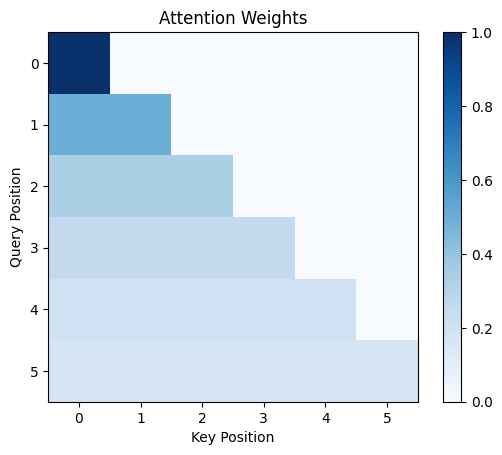

In [20]:

####  Add Visualization (Critical for Intuition)**  
import matplotlib.pyplot as plt

plt.imshow(wei.detach().numpy(), cmap='Blues')
plt.xlabel("Key Position")
plt.ylabel("Query Position")
plt.title("Attention Weights")
plt.colorbar()
plt.show()

## Step 3: Query, Key, Value (QKV) Attention  
Real attention uses learned **Query** (what I’m looking for), **Key** (what I contain), and **Value** (what I’ll share) vectors:  
- `q = query(x)`: How much the token "asks" about others.  
- `k = key(x)`: How much the token "answers" others' queries.  
- `v = value(x)`: Actual content shared.  

Scores (`wei = q @ k.T`) measure query-key compatibility.  

In [21]:
head_size = 2
key = nn.Linear(2, head_size, bias=False)
query = nn.Linear(2, head_size, bias=False)
value = nn.Linear(2, head_size, bias=False)
k = key(x)
q = query(x)
v = value(x)
print(f"shape of input: {x.shape}")
print(f"Query for all the 6 tokens: {q}, shape: {q.shape}")
print(f"Key for all the 6 tokens: {k}, shape: {k.shape}")


shape of input: torch.Size([6, 2])
Query for all the 6 tokens: tensor([[-0.8880,  1.9067],
        [ 0.1336, -0.4055],
        [ 0.4446,  0.3338],
        [ 0.0361,  0.0872],
        [-0.1925,  0.0850],
        [ 0.1336, -0.4055]], grad_fn=<MmBackward0>), shape: torch.Size([6, 2])
Key for all the 6 tokens: tensor([[ 0.7013, -2.1317],
        [-0.2415,  0.4191],
        [ 1.1257, -0.0024],
        [ 0.1603, -0.0501],
        [-0.2243, -0.1895],
        [-0.2415,  0.4191]], grad_fn=<MmBackward0>), shape: torch.Size([6, 2])


In [22]:
k.T

tensor([[ 0.7013, -0.2415,  1.1257,  0.1603, -0.2243, -0.2415],
        [-2.1317,  0.4191, -0.0024, -0.0501, -0.1895,  0.4191]],
       grad_fn=<PermuteBackward0>)

In [23]:
wei = q @ k.T # dot product the query of each token with the key of itself and all the other tokens 
wei, wei.shape

(tensor([[-4.6874e+00,  1.0137e+00, -1.0042e+00, -2.3785e-01, -1.6225e-01,
           1.0137e+00],
         [ 9.5800e-01, -2.0221e-01,  1.5131e-01,  4.1719e-02,  4.6900e-02,
          -2.0221e-01],
         [-3.9978e-01,  3.2535e-02,  4.9966e-01,  5.4525e-02, -1.6298e-01,
           3.2535e-02],
         [-1.6059e-01,  2.7838e-02,  4.0407e-02,  1.4131e-03, -2.4621e-02,
           2.7838e-02],
         [-3.1625e-01,  8.2131e-02, -2.1689e-01, -3.5109e-02,  2.7054e-02,
           8.2131e-02],
         [ 9.5800e-01, -2.0221e-01,  1.5131e-01,  4.1719e-02,  4.6900e-02,
          -2.0221e-01]], grad_fn=<MmBackward0>),
 torch.Size([6, 6]))

### Masking Future Tokens  
To prevent cheating in autoregressive models (like GPT), we mask future tokens by setting their scores to `-inf` before softmax:  
```python  
tril = torch.tril(torch.ones(6, 6))  # Lower triangular mask  
wei = wei.masked_fill(tril == 0, float("-inf"))  

In [24]:
# mask the weights for the futire tokens
tril = torch.tril(torch.ones(6,6))
wei = wei.masked_fill(tril ==0, float("-inf"))
print(f"weight matrix: {wei}")
# apply softmax to get the attention score
wei = F.softmax(wei, dim=-1)
print(f"score: {wei}")
out = wei @ v
print(f"output: {out}")



weight matrix: tensor([[-4.6874e+00,        -inf,        -inf,        -inf,        -inf,
                -inf],
        [ 9.5800e-01, -2.0221e-01,        -inf,        -inf,        -inf,
                -inf],
        [-3.9978e-01,  3.2535e-02,  4.9966e-01,        -inf,        -inf,
                -inf],
        [-1.6059e-01,  2.7838e-02,  4.0407e-02,  1.4131e-03,        -inf,
                -inf],
        [-3.1625e-01,  8.2131e-02, -2.1689e-01, -3.5109e-02,  2.7054e-02,
                -inf],
        [ 9.5800e-01, -2.0221e-01,  1.5131e-01,  4.1719e-02,  4.6900e-02,
         -2.0221e-01]], grad_fn=<MaskedFillBackward0>)
score: tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.7614, 0.2386, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2000, 0.3082, 0.4917, 0.0000, 0.0000, 0.0000],
        [0.2171, 0.2621, 0.2655, 0.2553, 0.0000, 0.0000],
        [0.1580, 0.2354, 0.1745, 0.2093, 0.2228, 0.0000],
        [0.3478, 0.1090, 0.1552, 0.1391, 0.1398, 0.1090]],
       grad_fn=

In [26]:
# Compare original vs. contextualized embeddings:  
# - `v`: Isolated token representations.  
# - `out`: Tokens now include context from previous words.  
print("Original values (no context):\\n", v)  
print("Contextualized outputs:\\n", out)  

Original values (no context):\n tensor([[ 0.9757, -0.4630],
        [-0.2114,  0.0699],
        [ 0.2133,  0.2291],
        [ 0.0501,  0.0185],
        [ 0.0327, -0.0997],
        [-0.2114,  0.0699]], grad_fn=<MmBackward0>)
Contextualized outputs:\n tensor([[ 0.9757, -0.4630],
        [ 0.6924, -0.3358],
        [ 0.2349,  0.0416],
        [ 0.2258, -0.0167],
        [ 0.1594, -0.0351],
        [ 0.3379, -0.1216]], grad_fn=<MmBackward0>)


## Final Output  
Each row in `out` is a new embedding combining information from past tokens via attention. Compare:  
- `v`: Original value vectors (no context).  
- `out`: Contextualized vectors (e.g., the second "cat" now knows about the first "cat").  

## Key Takeaways  
- Attention computes weighted sums of embeddings.  
- Masking ensures causality (no future peeking).  
- Q/K/V projections enable dynamic context mixing.  